In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from sklearn import preprocessing
import numpy as np
from multitcn_components import TCNStack, LearningRateLogger
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
import tensorflow_addons as tfa
import sys
from datetime import datetime
import uuid
import pyproj as proj


#Experiment Parameters:
WINDOW_SIZE = 24
FORECAST_HORIZON = 8

data = pd.read_csv("Datasets/TC/ibtracs.since1980.list.v04r00.csv")

data = data[["SID", "NAME", "BASIN", "ISO_TIME", "USA_WIND", "LAT", "LON", "STORM_SPEED", "STORM_DIR", "USA_PRES"]]

targets = ["LAT", "LON", "USA_WIND", "BASIN", "STORM_SPEED", "STORM_DIR", "USA_PRES", "DLAT", "DLON", "DSTORM_DIR", "DUSA_WIND"]
label_cols = ["LAT", "LON"]

data.drop(index=0, inplace=True)
data.replace(" ", pd.NA, inplace=True)
data["BASIN"].replace("SP", 1, inplace=True)
data["BASIN"].replace("SI", 2, inplace=True)
data["BASIN"].replace("WP", 3, inplace=True)
data["BASIN"].replace("EP", 4, inplace=True)
data["BASIN"].replace("NI", 5, inplace=True)
data["BASIN"].replace("SA", 6, inplace=True)
data[targets[0:6]] = data[targets[0:6]].apply(pd.to_numeric, errors="coerce")
data["BASIN"].fillna(0, inplace=True)
# ['SP' 'SI' 'WP' 'EP' 0 'NI' 'SA']
#    1    2    3    4      5    6
print(data["BASIN"].unique())


data = data.loc[data["BASIN"] == 0]

# crs_wgs = proj.Proj(init='epsg:4326') # assuming you're using WGS84 geographic
# crs_bng = proj.Proj(init='epsg:3857') # use a locally appropriate projected CRS
# x, y = proj.transform(crs_wgs, crs_bng, data["LON"], data["LAT"])

# data["LAT"] = y
# data["LON"] = x

for col in ["LAT", "LON", "STORM_DIR", "USA_WIND"]:
    data[col] = data[col].apply(pd.to_numeric, errors="coerce")
    data["D"+col] = data[col].diff()

#data.fillna(0, inplace=True)
"""data["LAT"] = data["LAT"].apply(pd.to_numeric, errors="coerce")
data["DLAT"] = data["LAT"].diff()
data["DLON"] = data["LON"].diff()
data["DDIR"] = data["DIR"].diff()
data["DWIND"] = data["USA_WIND"].diff()"""

#TODO: Add engineered features to targets list, modify code later on!

# for col in targets:
#     data[col] = data[col].apply(pd.to_numeric, errors="coerce")
#     data[col].fillna(data[col].mean(), inplace=True)

#print(data)
print(data.isna().sum())
print(data)

storms = data["SID"].unique()

data_normalizer = preprocessing.MinMaxScaler(feature_range=(-1,1))

numeric_fields = np.array(data[targets].apply(pd.to_numeric, errors="coerce").replace(" ", pd.NA).dropna())

data_normalizer.fit(numeric_fields)

valid_storms = []

2023-04-29 21:56:41.206801: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-29 21:56:41.230445: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-29 21:56:41.231047: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-29 21:56:41.785628: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/ramy/Dev/tcforecast/multivariate-attention-tcn/.nvenv/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a pl

[1. 2. 3. 4. 0. 5. 6.]
SID               0
NAME              0
BASIN             0
ISO_TIME          0
USA_WIND         34
LAT               0
LON               0
STORM_SPEED       0
STORM_DIR         0
USA_PRES       1731
DLAT              1
DLON              1
DSTORM_DIR        1
DUSA_WIND        51
dtype: int64
                  SID       NAME  BASIN             ISO_TIME  USA_WIND   
2773    1980199N31284  NOT_NAMED    0.0  1980-07-17 00:00:00      20.0  \
2774    1980199N31284  NOT_NAMED    0.0  1980-07-17 03:00:00      22.0   
2775    1980199N31284  NOT_NAMED    0.0  1980-07-17 06:00:00      25.0   
2776    1980199N31284  NOT_NAMED    0.0  1980-07-17 09:00:00      25.0   
2777    1980199N31284  NOT_NAMED    0.0  1980-07-17 12:00:00      25.0   
...               ...        ...    ...                  ...       ...   
286166  2022309N16290     NICOLE    0.0  2022-11-11 06:00:00      30.0   
286167  2022309N16290     NICOLE    0.0  2022-11-11 09:00:00      27.0   
286168  2022309N16

In [4]:
####### Set up experiment parameters ###############

#Logging parameters

experiment_id = str(uuid.uuid4())
now = datetime.now()
date_time_string = now.strftime("%d-%m-%Y-%H-%M-%S")
# For potential tensorboard use
log_dir="logs/profile/" + date_time_string
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch = 3)

#Training parameters
epochs = 120
batch_size = 64
starting_lr = 1e-3
optimizer = tfa.optimizers.AdamW(learning_rate=starting_lr, weight_decay=1e-4)
#optimizer = tf.keras.optimizers.Adam(starting_lr)
min_lr = 2e-5
loss = 'mse'

## Callbacks
log_name="logs/"+ F"{experiment_id}-{date_time_string}_train_history"
log_history_callback = CSVLogger(log_name)
early_stop_callback = EarlyStopping(monitor="loss", patience=3)
filepath= "weights/" + experiment_id+"-weights.{epoch:02d}-{val_loss:.4f}.tf"
save_model_callback = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', save_freq='epoch')
callbacks_list = [log_history_callback, save_model_callback, early_stop_callback]#, lr_reducer_callback]#, lr_log_callback, early_stopping_callback]


2023-04-29 21:56:48.048283: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2023-04-29 21:56:48.048304: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2023-04-29 21:56:48.048514: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.


In [5]:
for storm_id in storms:
    storm_dat = data.loc[data["SID"] == storm_id]

    if len(storm_dat) >= WINDOW_SIZE+FORECAST_HORIZON:
        storm_dat = storm_dat[targets + ["ISO_TIME"]]
        storm_dat["ISO_TIME"] = pd.to_datetime(storm_dat["ISO_TIME"], utc=True)
        storm_dat.asfreq(freq="3H")

        #storm_dat.replace(np.nan, pd.NA, inplace=True)


        storm_dat["USA_WIND"].interpolate(method="linear", inplace=True)
        storm_dat["USA_PRES"].interpolate(method="linear", inplace=True)
        storm_dat["LAT"].interpolate(method="linear", inplace=True)
        storm_dat["LON"].interpolate(method="linear", inplace=True)
        storm_dat["STORM_SPEED"].interpolate(method="linear", inplace=True)
        storm_dat["STORM_DIR"].interpolate(method="linear", inplace=True)
        #storm_dat["STORM_DIR_X"] = np.cos(storm_dat["STORM_DIR"])
        #storm_dat["STORM_DIR_X"] = np.cos(storm_dat["STORM_DIR"])
        
        for col in storm_dat.columns:
            storm_dat[col].bfill(inplace=True)
            storm_dat[col].ffill(inplace=True)
            storm_dat[col].fillna(storm_dat[col].mean(), inplace=True)
            if(storm_dat[col].isna().sum() > 0):
                storm_dat[col].fillna(data[col].apply(pd.to_numeric, errors="coerce").replace(" ", pd.NA).dropna().mean(), inplace=True)
        
        for col in ["LAT", "LON", "STORM_DIR", "USA_WIND"]:
            storm_dat["D"+col] = data[col].diff()
            storm_dat["D"+col].fillna(0, inplace=True)

        storm_dat[targets] = data_normalizer.transform(np.asarray(storm_dat[targets]))
        valid_storms.append(storm_dat)

print(len(valid_storms))

478


In [6]:
def windowed_dataset(series, time_series_number, window_size):
    """
    Returns a windowed dataset from a Pandas dataframe
    """
    available_examples= series.shape[0]-window_size + 1
    time_series_number = series.shape[1]
    inputs = np.zeros((available_examples,window_size,time_series_number))
    for i in range(available_examples):
        inputs[i,:,:] = series[i:i+window_size,:]
    return inputs 

def windowed_forecast(series, forecast_horizon):
    available_outputs = series.shape[0]- forecast_horizon + 1
    output_series_num = series.shape[1]
    output = np.zeros((available_outputs,forecast_horizon, output_series_num))
    for i in range(available_outputs):
        output[i,:]= series[i:i+forecast_horizon,:]
    return output

input_sequences = []
forecast_sequences = []

for storm in valid_storms:
    data_in = np.array(storm[targets])
    data_out = np.array(storm[label_cols])
    
    for seq in windowed_dataset(data_in[:-FORECAST_HORIZON], len(targets), WINDOW_SIZE):
        input_sequences.append(seq)

    for seq in windowed_forecast(data_out[WINDOW_SIZE:], FORECAST_HORIZON):
        forecast_sequences.append(seq)

In [7]:
input_sequences = np.array(input_sequences)
forecast_sequences = np.array(forecast_sequences)

forecast_sequences = np.transpose(forecast_sequences, [0, 2, 1])

samples = input_sequences.shape[0]

test_percentage = 0.05

train_x = input_sequences[0:int(samples*(1-test_percentage))]
train_y = [forecast_sequences[0:int(samples*(1-test_percentage)),i,:] for i in range(len(label_cols))]

test_x = input_sequences[int(samples*(1-test_percentage)):]
test_y = forecast_sequences[int(samples*(1-test_percentage)):]


In [8]:
print(train_x.shape)
print(np.array(train_y).shape)

(18227, 24, 11)
(2, 18227, 8)


In [9]:
##################### Initialize model parameters ########################
## For simplicity all time series TCNs have the same parameters, though it is relatively easy to change this
tcn_kernel_size = 3
tcn_layer_num = 7
tcn_use_bias = True
tcn_filter_num = 256
tcn_kernel_initializer = 'random_normal'
tcn_dropout_rate = 0.3 
tcn_dropout_format = "channel"
tcn_activation = 'relu'
tcn_final_activation = 'linear'
tcn_final_stack_activation = 'relu'
loss = [loss]*len(label_cols)

In [10]:
############## Set up model ##########################
class MTCNAModel(tf.keras.Model):
    
    def __init__(self,tcn_layer_num,tcn_kernel_size,tcn_filter_num,window_size,forecast_horizon, use_bias, kernel_initializer, tcn_dropout_rate,tcn_dropout_format,tcn_activation, tcn_final_activation, tcn_final_stack_activation):
        super(MTCNAModel, self).__init__()
        self.window_size = window_size
        self.tcn_filter_num = tcn_filter_num
        

        #Create stack of TCN layers    
        self.lower_tcn = TCNStack(tcn_layer_num,tcn_filter_num,tcn_kernel_size,window_size,use_bias,kernel_initializer,tcn_dropout_rate,tcn_dropout_format,tcn_activation,tcn_final_activation,tcn_final_stack_activation)
    
        #Create stack of dense layers
        self.lat_seq = tf.keras.models.Sequential()
        self.lat_seq.add(tf.keras.layers.Flatten())
        self.lat_seq.add(tf.keras.layers.Dense(forecast_horizon,activation=None))
        
        #Create stack of dense layers
        self.lon_seq = tf.keras.models.Sequential()
        self.lon_seq.add(tf.keras.layers.Flatten())
        self.lon_seq.add(tf.keras.layers.Dense(forecast_horizon,activation=None))
        
        #Create stack of dense layers
        """self.wind_seq = tf.keras.models.Sequential()
        self.wind_seq.add(tf.keras.layers.Flatten())
        self.wind_seq.add(tf.keras.layers.Dense(forecast_horizon,activation=None))"""
        
    def call(self, input_tensor):
        x = self.lower_tcn(input_tensor)
        lat = self.lat_seq(x)
        lon = self.lon_seq(x)
        #wind = self.wind_seq(x)
        return lat, lon

In [11]:
device = "CPU:0"

with tf.device(device):
        model = MTCNAModel(tcn_layer_num,tcn_kernel_size,tcn_filter_num,WINDOW_SIZE,FORECAST_HORIZON, tcn_use_bias, tcn_kernel_initializer, tcn_dropout_rate, tcn_dropout_format, tcn_activation, tcn_final_activation, tcn_final_stack_activation)
        model.compile(optimizer,loss,metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [12]:
def log_experiment_details(just_print=False, complete=False):
    """ Log experiment details """
    if just_print:
        o = sys.stdout
    else:
        o = open(date_time_string+"--"+experiment_id+".txt","w")
    o.write("=== DETAILS FOR TC FORECAST EXPERIMENT ====")
    o.write("Date and time: %s \n" % date_time_string)
    o.write("Experiment complete : %s\n" % str(complete))
    if complete:
        now = datetime.now()
        completion_time = now.strftime("%d-%m-%Y-%H-%M-%S")
        o.write("Experiment complete at: %s\n" % completion_time)

    o.write("Forecast targets: " + str(label_cols))
    o.write("\n\n")
    o.write(" Training parameters ".center(100,"="))
    o.write("\n\n")
    o.write("Batch size: %d\n" % batch_size)
    o.write("Epochs : %d\n" % epochs)
    o.write("Device used: %s\n" % device)
    o.write("Loss : %s\n" % loss)
    o.write("Optimizer config: %s" % str(optimizer.get_config()))
    o.write("\n\n")
    o.write(" Dataset parameters ".center(100,"="))
    o.write("\n\n")
    o.write("\n\n")
    o.write(" Specific model parameters ".center(100,"="))
    o.write("\n\n")
    o.write("tcn_kernel_size : %d\n" % tcn_kernel_size)
    o.write("tcn_filter_num : %d\n" % tcn_filter_num)
    o.write("tcn_layer_num : %d\n" % tcn_layer_num)
    o.write("tcn_use_bias : %s\n" % str(tcn_use_bias))
    o.write("tcn_kernel_initializer : %s\n" % tcn_kernel_initializer)
    o.write("tcn_dropout_rate : %0.2f\n" % tcn_dropout_rate)
    o.write("tcn_dropout_format : %s\n" % tcn_dropout_format)
    o.write("tcn_activation : %s\n" % tcn_activation)
    o.write("tcn_final_activation : %s\n" % tcn_final_activation)
    o.write("tcn_final_stack_activation : %s\n" % tcn_final_stack_activation)
    o.write("\n\n")
    o.write(" Additional useful notes ".center(100,"="))
    o.write("\n\n")
    o.write("\n\n")
    
    if not just_print:
        o.close()
    else:
        o.flush()

In [11]:
training_percentage = 0.95
log_experiment_details()

start_time = tf.timestamp()

history = model.fit(x=train_x, y=train_y,validation_split=(1-training_percentage), batch_size=batch_size, epochs=epochs, callbacks=callbacks_list)

end_time = tf.timestamp()

duration = end_time - start_time

experiment_complete = True
log_experiment_details(complete=True)

Epoch 1/120
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
271/271 [==============================] - 51s 171ms/step - loss: 0.0671 - output_1_loss: 0.0341 - output_2_loss: 0.0331 - output_1_root_mean_squared_error: 0.1846 - output_2_root_mean_squared_error: 0.1818 - val_loss: 0.0089 - val_output_1_loss: 0.0063 - val_output_2_loss: 0.0027 - val_output_1_root_mean_squared_error: 0.0791 - val_output_2_root_mean_squared_error: 0.0515
Epoch 2/120
271/271 [==============================] - 45s 168ms/step - loss: 0.0090 - output_1_loss: 0.0053 - output_2_loss: 0.0037 - output_1_root_mean_squared_error: 0.0727 - output_2_root_mean_squared_error: 0.0612 - val_loss: 0.0085 - val_output_1_loss: 0.0037 - val_output_2_loss: 0.0047 - val_output_1_root_mean_squared_error: 0.0610 - val_output_2_root_mean_squared_error: 0.0688
Epoch 3/120
271/271 [==

In [12]:
model.save_weights("good_weights/exp3")

In [13]:
model.load_weights("good_weights/exp3")

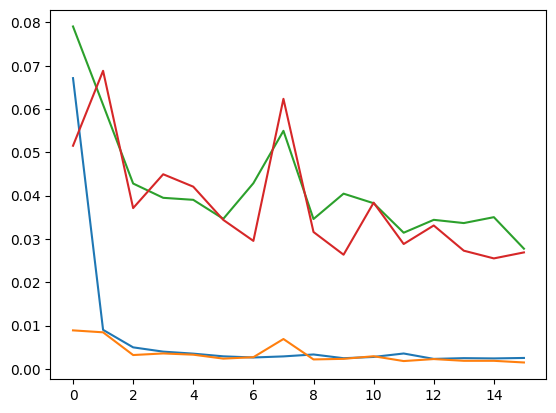

In [13]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.plot(history.history["val_output_1_root_mean_squared_error"])
plt.plot(history.history["val_output_2_root_mean_squared_error"])
plt.show()

In [14]:
print(test_x.shape)

(960, 24, 11)


In [268]:
storm_idx = 710

test_storm_x = np.array([test_x[storm_idx]])
test_storm_y = test_y[storm_idx]
#print(test_storm_x.shape)
#transformed = data_normalizer.inverse_transform(test_storm_x)

pred = model.predict(test_storm_x)

pred = np.array([x.flatten() for x in np.array(pred)])
print(pred)

1/1 [==============================] - 0s 16ms/step
[[0.0250065  0.04098541 0.05412168 0.06530565 0.07869028 0.09467113
  0.10726799 0.12668693]
 [0.1551887  0.17753185 0.1977978  0.21527568 0.23055279 0.2541266
  0.27325127 0.28649256]]


In [269]:
full_features = np.resize(pred, (len(targets), FORECAST_HORIZON))
ground_truth = data_normalizer.inverse_transform(np.resize(test_storm_y, (len(targets),FORECAST_HORIZON)).transpose((1,0)))
forecast = data_normalizer.inverse_transform(np.transpose(full_features, (1,0)))
past_track = data_normalizer.inverse_transform(test_storm_x[0])

forecast = np.transpose(forecast, (1, 0))
past_track = np.transpose(past_track, (1, 0))
ground_truth = np.transpose(ground_truth, (1,0))

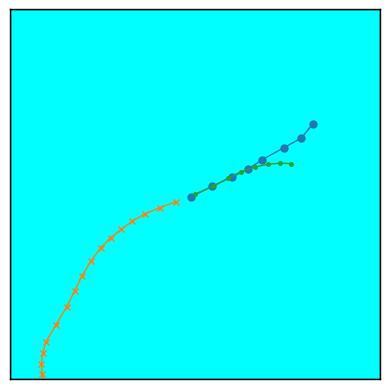

In [270]:
# ground_truth[[1,0]] = proj.transform(crs_bng, crs_wgs, ground_truth[1], ground_truth[0])
# forecast[[1,0]] = proj.transform(crs_bng, crs_wgs, forecast[1], forecast[0])
# past_track[[1,0]] = proj.transform(crs_bng, crs_wgs, past_track[1], past_track[0])

m = Basemap(projection="stere", width=1970000, height=1970000, lon_0=ground_truth[1][0], lat_0=ground_truth[0][0])
# draw coastlines.
m.drawcoastlines()
# draw a boundary around the map, fill the background.
# this background will end up being the ocean color, since
# the continents will be drawn on top.
m.drawmapboundary(fill_color='aqua')
# fill continents, set lake color same as ocean color.
m.fillcontinents(color='brown',lake_color='aqua')
m.drawcountries()
m.drawstates()

xf,yf = m(forecast[1], forecast[0])
xp,yp = m(past_track[1], past_track[0])
xg,yg = m(ground_truth[1], ground_truth[0])

m.plot(xf, yf, 'o-', markersize=5, linewidth=1)
m.plot(xp,yp,'x-', markersize=5, linewidth=1)
m.plot(xg,yg,'.-', markersize=5, linewidth=1)

plt.show()

In [271]:
import geopy.distance

evaluation = [0]*FORECAST_HORIZON
for j in range(FORECAST_HORIZON):
        flat = forecast[0][j]
        flon = forecast[1][j]

        glat = ground_truth[0][j]
        glon = ground_truth[1][j]

        dist = geopy.distance.geodesic((flat, flon),(glat, glon)).km
        
        evaluation[j]=dist

print(evaluation)

[25.879679474449933, 3.639109992748465, 23.066918839693805, 42.4297395291343, 57.67925981688851, 124.30094534878194, 176.33116503357098, 238.9393802321794]


In [272]:
esdf

NameError: name 'esdf' is not defined

In [ ]:
import geopy.distance

def forecast_storm(index: int):
    test_storm_x = np.array([test_x[storm_idx]])
    test_storm_y = test_y[storm_idx]

    pred = model.predict(test_storm_x)
    pred = np.array([x.flatten() for x in np.array(pred)])
    
    full_features = np.resize(pred, (len(targets), FORECAST_HORIZON))
    ground_truth = data_normalizer.inverse_transform(np.resize(test_storm_y, (len(targets),FORECAST_HORIZON)).transpose((1,0)))
    forecast = data_normalizer.inverse_transform(np.transpose(full_features, (1,0)))
    past_track = data_normalizer.inverse_transform(test_storm_x[0])

    forecast = np.transpose(forecast, (1, 0))
    past_track = np.transpose(past_track, (1, 0))
    ground_truth = np.transpose(ground_truth, (1,0))

    return forecast, past_track, ground_truth

evaluation = [0]*FORECAST_HORIZON
for i in range(len(test_x)):
    fcst, _, grnd = forecast_storm(i)
    for j in range(FORECAST_HORIZON):
        flat = fcst[0][j]
        flon = fcst[1][j]

        glat = grnd[0][j]
        glon = grnd[1][j]

        dist = geopy.distance.geodesic((flat, flon),(glat, glon)).km
        
        evaluation[j]+=dist
evaluation = np.array(evaluation) * (1/len(test_x))

1/1 [==============================] - 0s 12ms/step


KeyboardInterrupt: 

[79.86061263 62.8609353  28.13801213 52.30173595 54.22424145 65.3031834
 80.2220851  91.70475619]


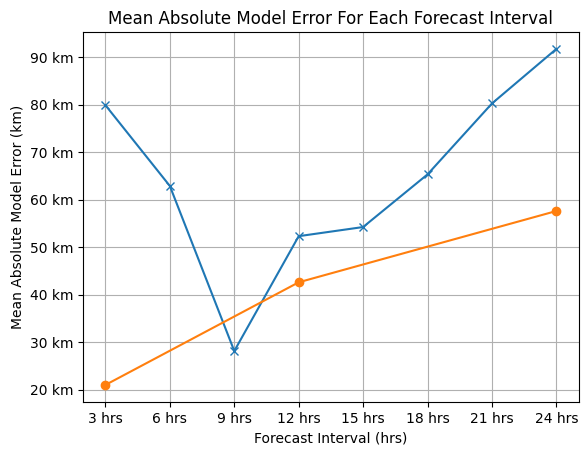

In [ ]:
from matplotlib.ticker import MultipleLocator

fig, ax = plt.subplots()
ax.plot([(n+1)*3 for n in range(FORECAST_HORIZON)], evaluation, 'x-')
ax.plot([3, 12, 24], [21, 23*1.852, 31.1*1.852], 'o-')
ax.xaxis.set_major_locator(MultipleLocator(3))
ax.xaxis.set_major_formatter('{x:.0f} hrs')
ax.yaxis.set_major_formatter('{x:.0f} km')
ax.set_xlabel("Forecast Interval (hrs)")
ax.set_ylabel("Mean Absolute Model Error (km)")
ax.set_title("Mean Absolute Model Error For Each Forecast Interval")
ax.grid()

print(evaluation)